0:	test: 0.6026302	best: 0.6026302 (0)	total: 95.9ms	remaining: 3m 11s
200:	test: 0.7743793	best: 0.7745964 (196)	total: 660ms	remaining: 5.91s
400:	test: 0.8148785	best: 0.8152083 (399)	total: 1.21s	remaining: 4.82s
600:	test: 0.8381684	best: 0.8381684 (600)	total: 1.77s	remaining: 4.12s
800:	test: 0.8509028	best: 0.8509028 (800)	total: 2.37s	remaining: 3.55s
1000:	test: 0.8587977	best: 0.8587977 (1000)	total: 2.92s	remaining: 2.91s
1200:	test: 0.8640929	best: 0.8643273 (1191)	total: 3.46s	remaining: 2.3s
1400:	test: 0.8670920	best: 0.8671224 (1399)	total: 4s	remaining: 1.71s
1600:	test: 0.8704818	best: 0.8707509 (1596)	total: 4.55s	remaining: 1.13s
1800:	test: 0.8726389	best: 0.8727778 (1794)	total: 5.09s	remaining: 562ms
1999:	test: 0.8749957	best: 0.8749957 (1999)	total: 5.63s	remaining: 0us

bestTest = 0.8749956597
bestIteration = 1999


=== CatBoost ===
Confusion Matrix:
 [[1214  226]
 [  42  118]]
              precision    recall  f1-score   support

           0     0.9666    

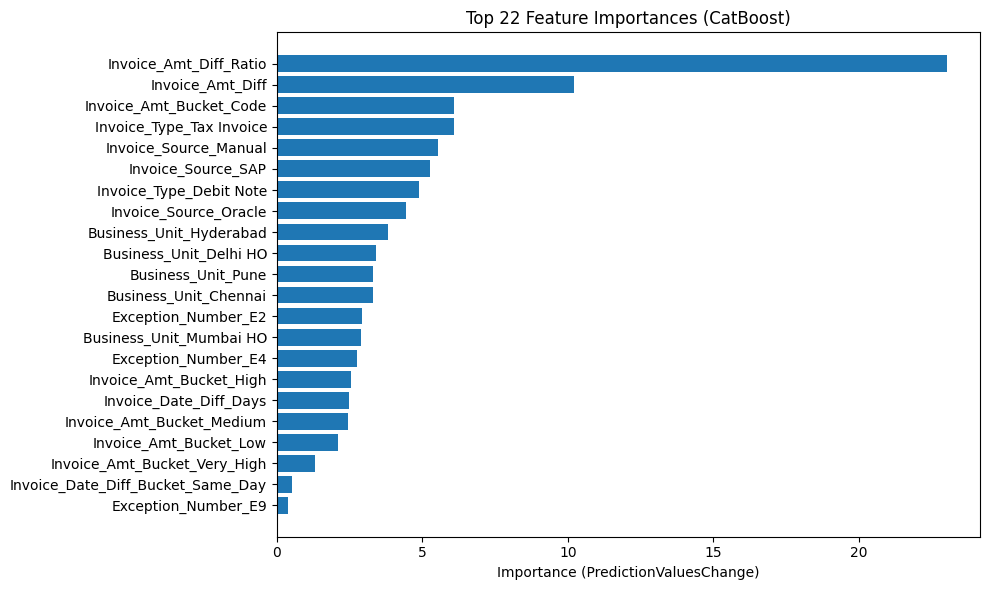

In [1]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    average_precision_score,
)
from catboost import CatBoostClassifier


# ==========================================================
# PATHS (single source of truth)
# ==========================================================
DATA_PATH = "D:/EY_Internship/p2p07_synthetic_10k_imbalance_with_pending.csv"

FEATURE_COLUMNS_PATH = "D:/EY_Internship/feature_columns.joblib"
INVOICE_BINS_PATH = "D:/EY_Internship/invoice_amt_bins.joblib"

CAT_MODEL_PATH = "catboost_model.cbm"
CAT_BUNDLE_PATH = "catboost_bundle.joblib"
CAT_FEATURE_IMPORTANCE_PATH = "catboost_feature_importances.csv"


# ==========================================================
# preprocess_p2p (unchanged)
# ==========================================================
def preprocess_p2p(
    df: pd.DataFrame,
    *,
    feature_columns: list[str] | None = None,
    invoice_amt_bins: np.ndarray | None = None,
    is_training: bool = False
):
    df = df.copy()

    df["Invoice_Amount"] = pd.to_numeric(df.get("Invoice_Amount"), errors="coerce")
    df = df.dropna(subset=["Invoice_Amount"])

    if is_training:
        _, bins = pd.qcut(df["Invoice_Amount"], q=5, retbins=True, duplicates="drop")
        invoice_amt_bins = bins

    if invoice_amt_bins is not None:
        labels = ["Very_Low", "Low", "Medium", "High", "Very_High"]
        effective_k = len(invoice_amt_bins) - 1
        effective_labels = labels[:effective_k]

        df["Invoice_Amt_Bucket"] = pd.cut(
            df["Invoice_Amount"],
            bins=invoice_amt_bins,
            labels=effective_labels,
            include_lowest=True
        )
        df["Invoice_Amt_Bucket_Code"] = df["Invoice_Amt_Bucket"].cat.codes.replace(-1, np.nan)
    else:
        df["Invoice_Amt_Bucket"] = pd.qcut(
            df["Invoice_Amount"], q=5,
            labels=["Very_Low", "Low", "Medium", "High", "Very_High"],
            duplicates="drop"
        )
        df["Invoice_Amt_Bucket_Code"] = pd.qcut(
            df["Invoice_Amount"], q=5, labels=False, duplicates="drop"
        )

    df = pd.get_dummies(df, columns=["Invoice_Amt_Bucket"], drop_first=True)

    df["Invoice_Date"] = pd.to_datetime(df.get("Invoice_Date"), errors="coerce", dayfirst=True)
    df["Posting_Date"] = pd.to_datetime(df.get("Posting_Date"), errors="coerce", dayfirst=True)

    dup_lookup = df[["Doc_id", "Invoice_Amount", "Invoice_Date"]].rename(
        columns={
            "Doc_id": "Duplicate_doc_id",
            "Invoice_Amount": "Dup_Invoice_Amount",
            "Invoice_Date": "Dup_Invoice_Date",
        }
    )
    df = df.merge(dup_lookup, on="Duplicate_doc_id", how="left")

    df["Invoice_Amt_Diff"] = (df["Invoice_Amount"] - df["Dup_Invoice_Amount"]).abs()
    df["Invoice_Date_Diff_Days"] = (df["Invoice_Date"] - df["Dup_Invoice_Date"]).dt.days.abs()
    df["Invoice_Amt_Diff_Ratio"] = df["Invoice_Amt_Diff"] / (df["Invoice_Amount"] + 1)

    def date_diff_bucket(x):
        if pd.isna(x):
            return np.nan
        if x == 0:
            return "Same_Day"
        elif x <= 2:
            return "1_2_Days"
        else:
            return "Above_2_Days"

    df["Invoice_Date_Diff_Bucket"] = df["Invoice_Date_Diff_Days"].apply(date_diff_bucket)

    DROP_COLS = [
        "Doc_id", "Invoice_ID", "Vendor_Code", "Vendor_Name",
        "Vendor_GSTIN", "Invoice_Number", "Currency", "comments",
        "Duplicate_doc_id", "Exception_Type",
        "Invoice_Amt_Bucket", "Invoice_Amount", "Dup_Invoice_Amount",
    ]
    df_model = df.drop(columns=DROP_COLS, errors="ignore")

    categorical_cols = [
        "Invoice_Type",
        "Invoice_Source",
        "Business_Unit",
        "Exception_Number",
        "Invoice_Date_Diff_Bucket",
    ]
    df_model = pd.get_dummies(df_model, columns=categorical_cols, drop_first=True)

    if is_training:
        feature_columns = df_model.columns.tolist()
    else:
        if feature_columns is None:
            raise ValueError("feature_columns is required for inference.")
        for c in feature_columns:
            if c not in df_model.columns:
                df_model[c] = 0
        extra = [c for c in df_model.columns if c not in feature_columns]
        if extra:
            df_model = df_model.drop(columns=extra)
        df_model = df_model[feature_columns]

    return df_model, feature_columns, invoice_amt_bins


# ==========================================================
# Helpers: Top-K metrics for triage usefulness
# ==========================================================
def topk_metrics(y_true: np.ndarray, y_proba: np.ndarray, top_frac: float = 0.10):
    y_true = np.asarray(y_true).astype(int)
    y_proba = np.asarray(y_proba)

    n = len(y_true)
    k = max(1, int(np.ceil(top_frac * n)))

    idx = np.argsort(-y_proba)[:k]
    y_top = y_true[idx]

    tp_top = y_top.sum()
    total_pos = y_true.sum()

    precision_at_k = tp_top / k
    recall_at_k = tp_top / total_pos if total_pos > 0 else 0.0
    return precision_at_k, recall_at_k, k


# ==========================================================
# Load raw data + schema
# ==========================================================
df = pd.read_csv(DATA_PATH)
feature_columns = joblib.load(FEATURE_COLUMNS_PATH)

# ==========================================================
# Learn invoice bins from TRUE/FALSE only
# ==========================================================
df_tf = df[df["user_action_status"].isin(["TRUE", "FALSE"])].copy()
_, _, invoice_amt_bins = preprocess_p2p(df_tf, is_training=True)
joblib.dump(invoice_amt_bins, INVOICE_BINS_PATH)

# ==========================================================
# Preprocess full dataset aligned to schema
# ==========================================================
df_model, _, _ = preprocess_p2p(
    df,
    feature_columns=feature_columns,
    invoice_amt_bins=invoice_amt_bins,
    is_training=False
)

# ==========================================================
# Build training set
# ==========================================================
mask_tf = df["user_action_status"].isin(["TRUE", "FALSE"])
df_train = df_model.loc[mask_tf].copy()

df_train["y"] = df.loc[df_train.index, "user_action_status"].map({
    "FALSE": 0,
    "TRUE": 1
})

X = df_train[feature_columns]
y = df_train["y"].astype(int)

# ==========================================================
# Train / test split
# ==========================================================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# ==========================================================
# CatBoost (with class weights)
# NOTE: We already one-hot encoded categories, so no cat_features passed.
# ==========================================================
pos = int((y_train == 1).sum())
neg = int((y_train == 0).sum())
# CatBoost expects weights per class [w0, w1]
class_weights = [1.0, (neg / pos) if pos > 0 else 1.0]

cat = CatBoostClassifier(
    iterations=2000,
    learning_rate=0.03,
    depth=6,
    l2_leaf_reg=3.0,
    loss_function="Logloss",
    eval_metric="AUC",
    class_weights=class_weights,
    random_seed=42,
    verbose=200,
    od_type="Iter",     # early stopping
    od_wait=200
)

cat.fit(X_train, y_train, eval_set=(X_test, y_test), use_best_model=True)

# ==========================================================
# Evaluation
# ==========================================================
y_pred = cat.predict(X_test).astype(int).ravel()
y_proba = cat.predict_proba(X_test)[:, 1]

print("\n=== CatBoost ===")
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred, digits=4))

acc = (y_pred == y_test.values).mean()
roc_auc = roc_auc_score(y_test, y_proba)
pr_auc = average_precision_score(y_test, y_proba)
p_at_10, r_at_10, k = topk_metrics(y_test.values, y_proba, top_frac=0.10)

print("Accuracy:", acc)
print("ROC-AUC:", roc_auc)
print("PR-AUC:", pr_auc)
print(f"Precision@Top10% (K={k}):", p_at_10)
print(f"Recall@Top10% (K={k}):", r_at_10)

# ==========================================================
# Save model artifacts
# ==========================================================
cat.save_model(CAT_MODEL_PATH)
joblib.dump(
    {"model_path": CAT_MODEL_PATH, "feature_columns": feature_columns},
    CAT_BUNDLE_PATH
)
print("\nSaved model:", CAT_MODEL_PATH)
print("Saved bundle:", CAT_BUNDLE_PATH)

# ==========================================================
# Feature importance (PredictionValuesChange)
# (CatBoost-style global importance)
# ==========================================================
fi = cat.get_feature_importance(type="PredictionValuesChange")
imp = pd.DataFrame({
    "feature": feature_columns,
    "importance": fi
}).sort_values("importance", ascending=False)

imp.to_csv(CAT_FEATURE_IMPORTANCE_PATH, index=False)
print("Saved feature importances:", CAT_FEATURE_IMPORTANCE_PATH)

topk_plot = 22
imp_plot = imp.head(topk_plot)

plt.figure(figsize=(10, 6))
plt.barh(imp_plot["feature"][::-1], imp_plot["importance"][::-1])
plt.xlabel("Importance (PredictionValuesChange)")
plt.title(f"Top {topk_plot} Feature Importances (CatBoost)")
plt.tight_layout()
plt.show()


In [2]:
import pandas as pd
import joblib
from catboost import CatBoostClassifier

# ==========================================================
# PATHS
# ==========================================================
PENDING_INPUT_PATH = "D:/EY_Internship/pending_for_review_100_rows_clean.csv"
PENDING_OUTPUT_PATH = "pending_with_predictions_catboost.csv"

CAT_MODEL_PATH = "catboost_model.cbm"   # saved by cat.save_model(...)
INVOICE_BINS_PATH = "D:/EY_Internship/invoice_amt_bins.joblib"
FEATURE_COLUMNS_PATH = "D:/EY_Internship/feature_columns.joblib"


# ==========================================================
# Load artifacts
# ==========================================================
cat_model = CatBoostClassifier()
cat_model.load_model(CAT_MODEL_PATH)

invoice_amt_bins = joblib.load(INVOICE_BINS_PATH)
feature_cols = joblib.load(FEATURE_COLUMNS_PATH)

# ==========================================================
# Load pending data
# ==========================================================
df_new = pd.read_csv(PENDING_INPUT_PATH)

# ==========================================================
# Preprocess (NO TRAINING, STRICT ALIGNMENT)
# ==========================================================
X_new, _, _ = preprocess_p2p(
    df_new,
    feature_columns=feature_cols,
    invoice_amt_bins=invoice_amt_bins,
    is_training=False
)

# ==========================================================
# Predict using CatBoost
# ==========================================================
proba = cat_model.predict_proba(X_new)[:, 1]

# Threshold can be tuned (example: 0.6)
pred = (proba >= 0.6).astype(int)

# ==========================================================
# Attach outputs
# ==========================================================
df_new["model_probability"] = proba
df_new["model_prediction"] = pred
df_new["model_label"] = df_new["model_prediction"].map({0: "LOW_RISK", 1: "HIGH_RISK"})

def triage_bucket(p):
    if p < 0.15:
        return "AUTO_CLEAR_LOW"
    elif p > 0.90:
        return "AUTO_FLAG_HIGH"
    else:
        return "MANUAL_REVIEW"

df_new["triage_bucket"] = df_new["model_probability"].apply(triage_bucket)

# ==========================================================
# Save
# ==========================================================
df_new.to_csv(PENDING_OUTPUT_PATH, index=False)
print("Saved pending predictions →", PENDING_OUTPUT_PATH)


Saved pending predictions → pending_with_predictions_catboost.csv
